Here I will comapre how chunk size effecrts run time, for a subset of the data to allow faster run times.

In [1]:
import numpy as np
from scipy.ndimage import maximum_filter, gaussian_filter, uniform_filter
import time 
from scipy import signal
import matplotlib.pyplot as plt
import dask as da
import dask_image.ndfilters
import zarr

In [2]:
#Params
hpf_width = 100 # order of 100
sdnorm_exp = 1 # range 0.8-1
npil_filt = gaussian_filter
npil_size = (1.0, 5.0, 5.0)
cv_filt = uniform_filter
cv_size = (1, 2, 2) # in dask needs to be int
int_thresh = 0


In [17]:
def minimal_corrmap_dask(movx, time_chunks = None, spatial_chunks = None):
    """Input 4-D dask array form (t,z,y,x)"""
    nt,nz,ny,nx = movx.shape

    # Here is naive rechunk based of the number of cores I have and to chunk so chunks are [100MB-1GB]
    if time_chunks != None:
        time_chunks = time_chunks
    else:
        time_chunks = (10,nz,ny,nx)

    if spatial_chunks != None:  
        spatial_chunks = spatial_chunks
    else:
        spatial_chunks = (-1,nz, ny//12, nx//12)

    

    #basic highpass filter
    movx.rechunk(spatial_chunks)
    mov_hpf = da.array.zeros_like(movx)
    for i in range(0, nt, hpf_width):
        mov_hpf[i:i+hpf_width] = movx[i:i+hpf_width] - movx[i:i+hpf_width].mean(axis=0) # subtracts mean of a width

    sdmov = (((da.array.diff(mov_hpf, axis=0) ** 2).sum(axis=0)) / nt)**0.5  #standard deviation of each array point through time
    sdmov = da.array.maximum(10 ** -9,sdmov) # CHECK THIS BIT WITH ALI

    norm_mov = mov_hpf / (sdmov ** sdnorm_exp) #normalised the HPF movie .. probably current error

    del mov_hpf
    del sdmov 

    norm_mov.rechunk(time_chunks)

    c1 = dask_image.ndfilters.gaussian_filter(da.array.ones((nz,ny,nx)), sigma = npil_size, mode='constant')
    #c2 = dask_image.ndfilters.uniform_filter(da.array.ones((nz,ny,nx)), cv_size, mode='constant')

    #each time step apply the neuropil filter
    np_mov = da.array.zeros_like(movx)
    for i in range(len(movx[0])):
        np_mov[i] = dask_image.ndfilters.gaussian_filter(norm_mov[i], sigma = npil_size, mode='constant') / c1


    np_sub_mov = norm_mov - np_mov # removes the neuropil from the normalised image

    del np_mov
    del norm_mov

    #applies a cell detection filter
    cv_mov = da.array.zeros_like(movx)
    for i in range(len(movx[0])):
        cv_mov[i] = dask_image.ndfilters.uniform_filter(np_sub_mov[i], cv_size, mode='constant') * cv_size[-1]

    del np_sub_mov

    #removes values below a threshold defult = 0, and sum over time
    cv_mov.rechunk(spatial_chunks)
    vmap = (((cv_mov ** 2) * (cv_mov > int_thresh).astype(int)).sum(axis=0) ** 0.5)

    return vmap


Text(0, 0.5, 'Time ')

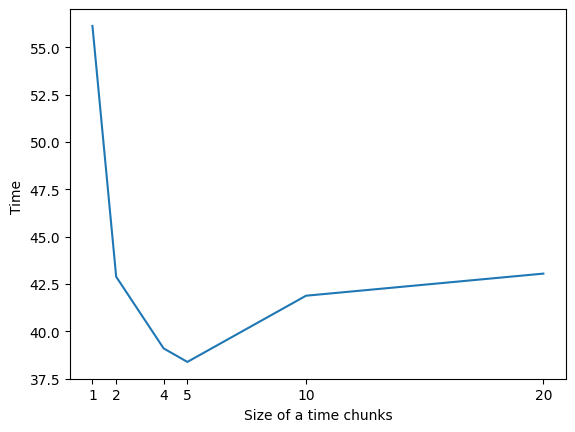

In [19]:
#what chunks you want to test
select = [(1,-1,-1,-1),(2,-1,-1,-1), (4,-1,-1,-1),(5,-1,-1,-1), (10,-1,-1,-1), (20,-1,-1,-1)]


times = np.zeros(len(select))
size_t_chunks = np.zeros(len(select))



data = da.array.from_zarr('test_data_larger.zarr').persist()

for i in range(len(select)):
    start = time.time()
    vmap = minimal_corrmap_dask(data, time_chunks = select[i])
    vmap = vmap.compute()
    final = time.time()

    times[i] = final - start
    size_t_chunks[i] = select[i][0]


plt.plot(size_t_chunks, times)
plt.xticks(size_t_chunks)
plt.xlabel('Size of a time chunks')
plt.ylabel('Time ')



Text(0, 0.5, 'Time ')

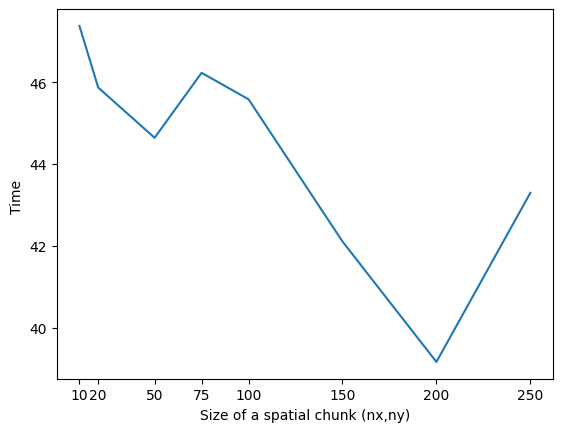

In [21]:
# as nz = 30 I am keeping that unchunked,  for simplicty as well as nx = ny

select = [(-1,-1,10,10),(-1,-1,20,20),(-1,-1,50,50), (-1,-1,75,75), (-1,-1,100,100), (-1,-1,150,150), (-1,-1,200,200), (-1,-1,250,250)]

times = np.zeros(len(select))
size_spatial_chunks = np.zeros(len(select))



data = da.array.from_zarr('test_data_larger.zarr').persist()

for i in range(len(select)):
    start = time.time()
    vmap = minimal_corrmap_dask(data, spatial_chunks = select[i])
    vmap = vmap.compute()
    final = time.time()

    times[i] = final - start
    size_spatial_chunks[i] = select[i][3]


plt.plot(size_spatial_chunks, times)
plt.xticks(size_spatial_chunks)
plt.xlabel('Size of a spatial chunk (nx,ny)')
plt.ylabel('Time ')
